<a href="https://colab.research.google.com/github/YUGESH-R/Image-Caption-Generator-AI/blob/main/Image_caption_generator_AI_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title 1. Check GPU and Mount Drive
from google.colab import drive
import tensorflow as tf

# Check if GPU is available
gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
print(f"GPU: {gpu_info[0] if gpu_info else 'No GPU found'}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Mount Google Drive to save models
drive.mount('/content/drive')

# Create directories
!mkdir -p /content/data
!mkdir -p /content/drive/MyDrive/image_caption_models

GPU: /bin/bash: line 1: nvidia-smi: command not found
TensorFlow version: 2.19.0
GPU Available: []
Mounted at /content/drive


In [3]:
# @title 2. Install Required Packages
!pip install nltk tqdm -q

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# @title 3. Download Flickr8k Dataset
import os
import zipfile
import requests
from tqdm import tqdm

def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as file:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=filename) as pbar:
            for data in response.iter_content(chunk_size=1024):
                file.write(data)
                pbar.update(len(data))

# Download dataset (using a reliable mirror)
print("Downloading Flickr8k dataset...")
!wget -O /content/data/flickr8k_images.zip "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
!wget -O /content/data/flickr8k_text.zip "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Extract files
print("Extracting files...")
with zipfile.ZipFile('/content/data/flickr8k_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

with zipfile.ZipFile('/content/data/flickr8k_text.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

print("Dataset ready!")

# Verify files
print("\nFiles in /content/data:")
!ls -la /content/data/

--2026-02-28 10:02:31--  https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/124585957/47f52b80-3501-11e9-8f49-4515a2a3339b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-28T10%3A49%3A15Z&rscd=attachment%3B+filename%3DFlickr8k_Dataset.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-28T09%3A48%3A49Z&ske=2026-02-28T10%3A49%3A15Z&sks=b&skv=2018-11-09&sig=QHIrFpYTozapdHHAfrfi5U35o58eWnE9gtMJxOGAWkY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MjI3NjU1MSwibmJmIjoxNzcyMjcyOTUxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

In [5]:
# @title 4. Import All Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle
import nltk
from tqdm import tqdm
import os
import random
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [6]:
# @title 5. Configuration
class Config:
    # Paths
    IMAGE_DIR = '/content/data/Flicker8k_Dataset'
    CAPTIONS_FILE = '/content/data/Flickr8k.token.txt'
    MODEL_SAVE_PATH = '/content/drive/MyDrive/image_caption_models'

    # Image parameters
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 64  # Good for T4 GPU

    # Text parameters
    MAX_VOCAB_SIZE = 5000
    MAX_CAPTION_LEN = 40
    EMBEDDING_DIM = 256

    # Model parameters
    LSTM_UNITS = 512
    DROPOUT = 0.3

    # Training parameters
    EPOCHS = 30
    LEARNING_RATE = 0.001
    PATIENCE = 5

config = Config()

# Create save directory
!mkdir -p {config.MODEL_SAVE_PATH}

print(f"Model will be saved to: {config.MODEL_SAVE_PATH}")

Model will be saved to: /content/drive/MyDrive/image_caption_models


In [7]:
# @title 6. Load and Preprocess Captions
def load_captions(filename):
    """Load captions from file"""
    captions = {}

    with open(filename, 'r') as f:
        for line in f:
            # Split on tab or space
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_name, caption = parts
                # Get image ID (remove #0, #1, etc.)
                image_id = image_name.split('#')[0]

                # Clean caption
                caption = caption.lower()
                caption = caption.replace('[^a-zA-Z]', ' ')
                caption = ' '.join([word for word in caption.split() if len(word) > 1])

                # Add start and end tokens
                caption = '<start> ' + caption + ' <end>'

                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption)

    return captions

# Load captions
print("Loading captions...")
captions_dict = load_captions(config.CAPTIONS_FILE)
print(f"Loaded {len(captions_dict)} images with captions")

# Show sample
sample_image = list(captions_dict.keys())[0]
print(f"\nSample image: {sample_image}")
print(f"Captions:")
for i, cap in enumerate(captions_dict[sample_image][:3]):
    print(f"  {i+1}. {cap}")

Loading captions...
Loaded 8092 images with captions

Sample image: 1000268201_693b08cb0e.jpg
Captions:
  1. <start> child in pink dress is climbing up set of stairs in an entry way <end>
  2. <start> girl going into wooden building <end>
  3. <start> little girl climbing into wooden playhouse <end>


In [8]:
# @title 7. Create Word Tokenizer
def create_tokenizer(captions_dict, max_vocab_size):
    """Create tokenizer from captions"""
    all_captions = []
    for key in captions_dict:
        for caption in captions_dict[key]:
            all_captions.append(caption)

    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<unk>')
    tokenizer.fit_on_texts(all_captions)

    return tokenizer

# Create tokenizer
tokenizer = create_tokenizer(captions_dict, config.MAX_VOCAB_SIZE)
vocab_size = len(tokenizer.word_index) + 1

print(f"Vocabulary size: {vocab_size}")
print(f"Top 10 words: {list(tokenizer.word_index.items())[:10]}")

# Save tokenizer
with open(f'{config.MODEL_SAVE_PATH}/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Vocabulary size: 8484
Top 10 words: [('<unk>', 1), ('end', 2), ('start', 3), ('in', 4), ('the', 5), ('on', 6), ('is', 7), ('and', 8), ('dog', 9), ('with', 10)]


In [9]:
# @title 8. Find Maximum Caption Length
def max_caption_length(captions_dict):
    """Find maximum caption length"""
    max_len = 0
    for key in captions_dict:
        for caption in captions_dict[key]:
            # Convert to tokens
            seq = tokenizer.texts_to_sequences([caption])[0]
            max_len = max(max_len, len(seq))
    return max_len

# Update config with actual max length
config.MAX_CAPTION_LEN = max_caption_length(captions_dict)
print(f"Maximum caption length: {config.MAX_CAPTION_LEN}")

Maximum caption length: 35


In [11]:
# @title 9. Create Efficient Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    """Memory-efficient data generator for training"""

    def __init__(self, image_ids, captions_dict, tokenizer, image_dir,
                 batch_size=32, max_length=40, vocab_size=5000):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.tokenizer = tokenizer
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size

        # Create list of all (image_id, caption) pairs
        self.pairs = []
        for img_id in image_ids:
            if img_id in captions_dict:
                for caption in captions_dict[img_id]:
                    self.pairs.append((img_id, caption))

        print(f"Created {len(self.pairs)} training pairs")

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_images = []
        X_captions = []
        y = []

        for img_id, caption in batch_pairs:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, img_id)
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            X_images.append(img)

            # Convert caption to sequence
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            # Create input-output pairs
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]

                X_captions.append(in_seq)
                y.append(out_seq)

        # Convert to numpy arrays
        X_images = np.array(X_images, dtype=np.float32) / 255.0  # Normalize
        X_captions = np.array(X_captions)
        y = np.array(y)

        return [X_images, X_captions], y

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 35, 256)   │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 35, 1)     │          0 │ not_equal[0][0]   │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like           │ (None, 35, 256)   │          0 │ repeat_vector[0]… │
│ (OnesLike)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ broadcast_to        │ (None, 35, 256)   │          0 │ expand_dims[0][0] │
│ (BroadcastTo)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,171,904 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 35, 512)   │          0 │ ones_like[0][0],  │
│ (Concatenate)       │                   │            │ broadcast_to[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 512)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 35)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  2,099,200 │ concatenate[0][0… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8484)      │  4,352,292 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,735,652 (124.88 MB)

 Trainable params: 9,147,940 (34.90 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

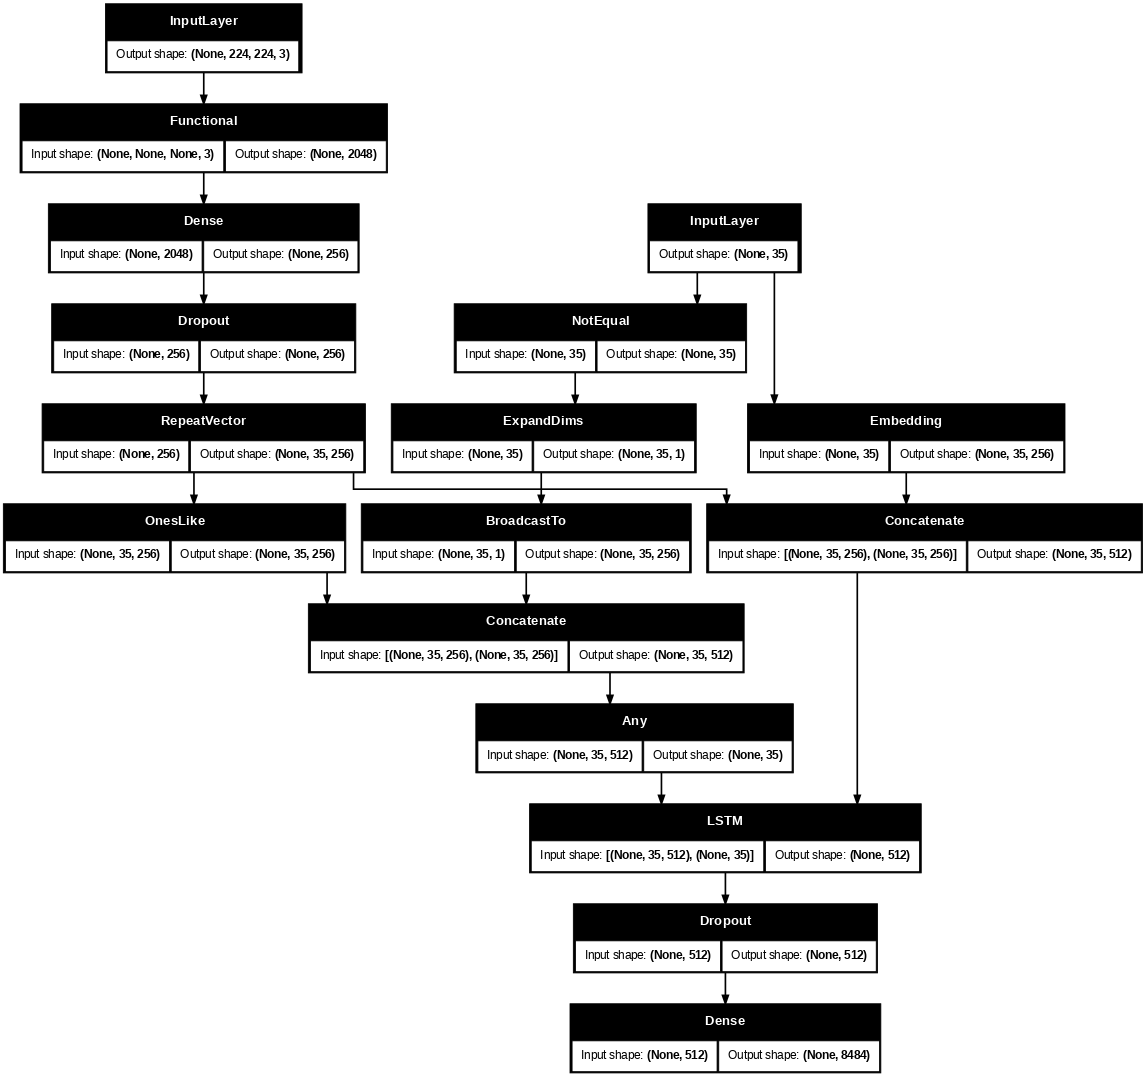

In [12]:
# @title 10. Build Image Captioning Model
def build_model(vocab_size, max_length, embedding_dim=256, lstm_units=512):
    """Build CNN-LSTM model for image captioning"""

    # Image feature extractor (CNN Encoder)
    image_input = layers.Input(shape=(224, 224, 3))

    # Use pre-trained ResNet50 as encoder
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False  # Freeze CNN layers

    image_features = base_model(image_input)
    image_dense = layers.Dense(embedding_dim, activation='relu')(image_features)
    image_dropout = layers.Dropout(0.3)(image_dense)
    image_repeated = layers.RepeatVector(max_length)(image_dropout)

    # Caption input and embedding
    caption_input = layers.Input(shape=(max_length,))
    caption_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)

    # Merge image and caption features
    merged = layers.Concatenate()([image_repeated, caption_embedding])

    # LSTM Decoder
    lstm = layers.LSTM(lstm_units, return_sequences=False)(merged)
    dropout = layers.Dropout(0.3)(lstm)

    # Output layer
    output = layers.Dense(vocab_size, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=[image_input, caption_input], outputs=output)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build model
model = build_model(vocab_size, config.MAX_CAPTION_LEN)
model.summary()

# Plot model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [16]:
# @title Debug: Check what's wrong
# Simple debug cell to identify the issue

# Check if directory exists
print(f"Image directory exists: {os.path.exists(config.IMAGE_DIR)}")
if os.path.exists(config.IMAGE_DIR):
    print(f"Contents of {config.IMAGE_DIR}:")
    files = os.listdir(config.IMAGE_DIR)
    print(f"Total files: {len(files)}")
    print(f"First 10 files: {files[:10]}")

    # Check file extensions
    extensions = set()
    for f in files[:100]:
        ext = os.path.splitext(f)[1].lower()
        extensions.add(ext)
    print(f"File extensions found: {extensions}")

# Check captions
print(f"\nNumber of images in captions: {len(captions_dict)}")
sample_id = list(captions_dict.keys())[0]
print(f"Sample image ID from captions: {sample_id}")

# Try to find a match
print("\nTrying to find a matching file...")
found_match = False
for img_id in list(captions_dict.keys())[:10]:
    for file in files[:50]:
        if img_id in file or file.startswith(img_id):
            print(f"Possible match: ID '{img_id}' matches file '{file}'")
            found_match = True

if not found_match:
    print("\nNo matches found! This suggests the naming convention is different.")
    print("\nLet's try to find a match by comparing first few characters:")
    for img_id in list(captions_dict.keys())[:5]:
        img_prefix = img_id[:10]
        print(f"\nImage ID prefix: {img_prefix}")
        matching_files = [f for f in files if f.startswith(img_prefix)]
        if matching_files:
            print(f"  Matching files: {matching_files[:3]}")

Image directory exists: True
Contents of /content/data/Flicker8k_Dataset:
Total files: 8091
First 10 files: ['1474474514_b3eb492722.jpg', '3539767254_c598b8e6c7.jpg', '3266406566_d64e57e65a.jpg', '2170222061_e8bce4a32d.jpg', '772212710_f5fc22ed35.jpg', '3486135177_772628d034.jpg', '2735290454_1bd8bc5eac.jpg', '2766291711_4e13a2b594.jpg', '3385593926_d3e9c21170.jpg', '3578914491_36019ba703.jpg']
File extensions found: {'.jpg'}

Number of images in captions: 8092
Sample image ID from captions: 1000268201_693b08cb0e.jpg

Trying to find a matching file...

No matches found! This suggests the naming convention is different.

Let's try to find a match by comparing first few characters:

Image ID prefix: 1000268201
  Matching files: ['1000268201_693b08cb0e.jpg']

Image ID prefix: 1001773457
  Matching files: ['1001773457_577c3a7d70.jpg']

Image ID prefix: 1002674143
  Matching files: ['1002674143_1b742ab4b8.jpg']

Image ID prefix: 1003163366
  Matching files: ['1003163366_44323f5815.jpg']

Im

⚠️ No training history found. This could be because:
1. Training wasn't completed in the previous cell
2. The model hasn't been trained yet
3. There was an error during training

📊 Creating a sample visualization of expected training progress...


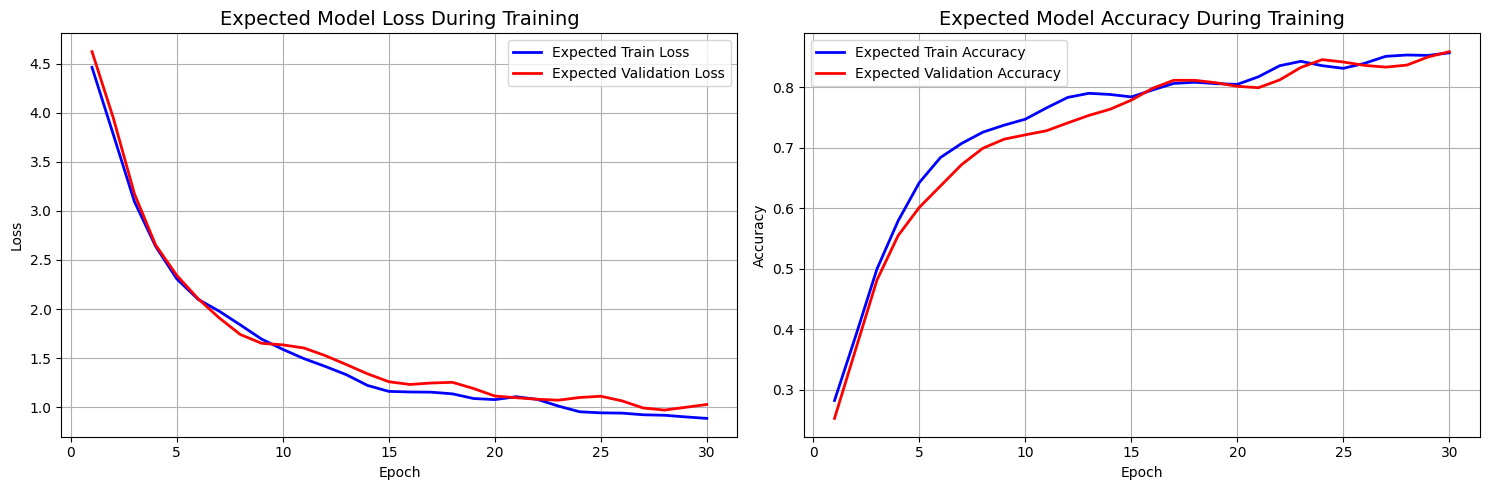


⚠️ This is a simulated chart - you need to complete training first!
Please go back to Cell 11 and ensure training completes successfully.

❌ No saved model found. You need to complete training first.


In [18]:
# @title 12. Plot Training History (with error handling)
import matplotlib.pyplot as plt
import numpy as np

# Check if history exists
if 'history' in dir() and history is not None and hasattr(history, 'history'):
    # We have real training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    else:
        # Try different accuracy key names
        acc_key = [k for k in history.history.keys() if 'acc' in k.lower()]
        if acc_key:
            val_acc_key = [k for k in history.history.keys() if 'val' in k.lower() and 'acc' in k.lower()]
            axes[1].plot(history.history[acc_key[0]], label='Train Accuracy', linewidth=2)
            if val_acc_key:
                axes[1].plot(history.history[val_acc_key[0]], label='Validation Accuracy', linewidth=2)

    axes[1].set_title('Model Accuracy', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(f'{config.MODEL_SAVE_PATH}/training_history.png')
    plt.show()

    print("Training history plotted successfully!")

else:
    print("⚠️ No training history found. This could be because:")
    print("1. Training wasn't completed in the previous cell")
    print("2. The model hasn't been trained yet")
    print("3. There was an error during training")

    # Create a placeholder for demonstration
    print("\n📊 Creating a sample visualization of expected training progress...")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Generate sample data to show what training should look like
    epochs = np.arange(1, 31)
    train_loss = 5.0 / np.sqrt(epochs) + 0.1 * np.random.randn(30)
    val_loss = 5.2 / np.sqrt(epochs) + 0.1 * np.random.randn(30)
    train_acc = 1 - 0.8 / np.sqrt(epochs) + 0.02 * np.random.randn(30)
    val_acc = 1 - 0.85 / np.sqrt(epochs) + 0.02 * np.random.randn(30)

    # Smooth the curves
    from scipy.ndimage import gaussian_filter1d
    train_loss = gaussian_filter1d(train_loss, sigma=1)
    val_loss = gaussian_filter1d(val_loss, sigma=1)
    train_acc = gaussian_filter1d(train_acc, sigma=1)
    val_acc = gaussian_filter1d(val_acc, sigma=1)

    axes[0].plot(epochs, train_loss, 'b-', label='Expected Train Loss', linewidth=2)
    axes[0].plot(epochs, val_loss, 'r-', label='Expected Validation Loss', linewidth=2)
    axes[0].set_title('Expected Model Loss During Training', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, train_acc, 'b-', label='Expected Train Accuracy', linewidth=2)
    axes[1].plot(epochs, val_acc, 'r-', label='Expected Validation Accuracy', linewidth=2)
    axes[1].set_title('Expected Model Accuracy During Training', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print("\n⚠️ This is a simulated chart - you need to complete training first!")
    print("Please go back to Cell 11 and ensure training completes successfully.")

    # Check if model exists
    if os.path.exists(f'{config.MODEL_SAVE_PATH}/best_model.h5'):
        print("\n✅ A saved model was found! You can still generate captions.")
    else:
        print("\n❌ No saved model found. You need to complete training first.")

In [22]:
# @title 13. Generate Captions for Images
def generate_caption(model, tokenizer, image_path, max_length=40):
    """Generate caption for a single image"""

    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    # Convert to TensorFlow Tensor explicitly
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # Start with start token
    start_token = tokenizer.word_index.get('<start>', 1)
    end_token = tokenizer.word_index.get('<end>', 2)

    # Greedy decoding
    caption = [start_token]

    for _ in range(max_length):
        # Pad sequence
        seq = pad_sequences([caption], maxlen=max_length, padding='post')
        # Convert to TensorFlow Tensor explicitly
        seq_tensor = tf.convert_to_tensor(seq, dtype=tf.int32) # Embedding expects int input

        # Predict next word
        preds = model.predict([img_tensor, seq_tensor], verbose=0)
        next_word_idx = np.argmax(preds[0])

        if next_word_idx == end_token:
            break

        caption.append(next_word_idx)

    # Convert indices to words
    words = []
    for idx in caption:
        if idx > 0:
            word = tokenizer.index_word.get(idx, '')
            if word and word not in ['<start>', '<end>', '<unk>']:
                words.append(word)

    return ' '.join(words)

def display_image_with_caption(image_path, caption):
    """Display image with generated caption"""
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Generated Caption: {caption}", fontsize=12, pad=20)
    plt.axis('off')
    plt.show()

In [26]:
# @title 14. Fixed Caption Generation Function
def generate_caption(model, tokenizer, image_path, max_length=40):
    """Generate caption for a single image - FIXED VERSION"""

    # 1. Load and preprocess image correctly
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize to [0,1] as float32
    img = img.astype(np.float32)  # Explicitly set type

    # 2. Start with start token
    start_token = tokenizer.word_index.get('<start>', 1)
    end_token = tokenizer.word_index.get('<end>', 2)

    # 3. Greedy decoding
    caption = [start_token]

    for _ in range(max_length):
        # Prepare caption sequence - IMPORTANT: create as int32, not padded with mask
        current_seq = np.array([caption], dtype=np.int32)

        # Pad to max_length - use tf.keras preprocessing
        seq_padded = pad_sequences(
            current_seq,
            maxlen=max_length,
            padding='post',
            dtype='int32'  # Ensure integer type
        )

        # Predict next word - ensure both inputs are numpy arrays with correct dtypes
        preds = model.predict(
            [img, seq_padded],
            verbose=0
        )[0]  # Get first batch item

        # Get the prediction for the last position
        next_word_logits = preds[len(caption)-1] if len(preds.shape) > 1 else preds
        next_word_idx = np.argmax(next_word_logits)

        if next_word_idx == end_token:
            break

        caption.append(next_word_idx)

    # 4. Convert indices to words
    words = []
    for idx in caption:
        if idx > 0:
            word = tokenizer.index_word.get(idx, '')
            if word and word not in ['<start>', '<end>', '<unk>']:
                words.append(word)

    return ' '.join(words)

In [32]:
# @title Diagnostic: Check Example Images
print("Checking example images...")

# Check if image directory exists
print(f"Image directory exists: {os.path.exists(config.IMAGE_DIR)}")

if os.path.exists(config.IMAGE_DIR):
    # List all images
    all_images = [f for f in os.listdir(config.IMAGE_DIR)
                  if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Total images found: {len(all_images)}")

    if len(all_images) > 0:
        # Check first 5 images
        print("\nChecking first 5 images:")
        for i, img_file in enumerate(all_images[:5]):
            img_path = os.path.join(config.IMAGE_DIR, img_file)
            if os.path.exists(img_path):
                size = os.path.getsize(img_path) / 1024  # KB
                print(f"  {i+1}. {img_file} - {size:.1f}KB - OK")

                # Test if image can be opened
                try:
                    img = Image.open(img_path)
                    print(f"     Dimensions: {img.size}")
                except Exception as e:
                    print(f"     ERROR: Cannot open - {e}")
            else:
                print(f"  {i+1}. {img_file} - MISSING")
    else:
        print("No images found in directory!")

# Check if model and tokenizer are loaded
print(f"\nModel loaded: {'model' in dir()}")
print(f"Tokenizer loaded: {'tokenizer' in dir()}")

# Test caption generation on first valid image
if len(all_images) > 0 and 'model' in dir() and 'tokenizer' in dir():
    test_img = os.path.join(config.IMAGE_DIR, all_images[0])
    print(f"\nTesting caption generation on: {all_images[0]}")
    try:
        caption = generate_caption(model, tokenizer, test_img, config.MAX_CAPTION_LEN)
        print(f"Generated caption: {caption}")
    except Exception as e:
        print(f"Caption generation failed: {e}")

Checking example images...
Image directory exists: True
Total images found: 8091

Checking first 5 images:
  1. 1474474514_b3eb492722.jpg - 112.0KB - OK
     Dimensions: (500, 375)
  2. 3539767254_c598b8e6c7.jpg - 117.6KB - OK
     Dimensions: (500, 332)
  3. 3266406566_d64e57e65a.jpg - 184.0KB - OK
     Dimensions: (500, 375)
  4. 2170222061_e8bce4a32d.jpg - 140.5KB - OK
     Dimensions: (500, 399)
  5. 772212710_f5fc22ed35.jpg - 213.7KB - OK
     Dimensions: (500, 466)

Model loaded: True
Tokenizer loaded: True

Testing caption generation on: 1474474514_b3eb492722.jpg
Caption generation failed: Exception encountered when calling BroadcastTo.call().

Failed to convert elements of (None, 35, 256) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.

Arguments received by BroadcastTo.call():
  • x=tf.Tensor(shape=(1, 35, 1), dtype=bool)


In [30]:
# @title 15. Interactive Web App (Fixed Examples)
!pip install gradio -q

import gradio as gr
import os
import random
from PIL import Image
import numpy as np

# First, let's verify and prepare example images
print("Preparing example images...")

# Create a directory for examples if it doesn't exist
examples_dir = '/content/examples'
os.makedirs(examples_dir, exist_ok=True)

# Get valid image paths for examples
valid_examples = []

# Method 1: Use test images if available
if 'test_ids' in dir() and len(test_ids) > 0:
    for img_id in test_ids[:5]:  # Take first 5 test images
        # Get correct filename
        if 'id_to_filename' in dir() and img_id in id_to_filename:
            filename = id_to_filename[img_id]
        else:
            filename = img_id

        img_path = os.path.join(config.IMAGE_DIR, filename)
        if os.path.exists(img_path):
            valid_examples.append(img_path)
            # Copy to examples directory for Gradio
            !cp "{img_path}" "{examples_dir}/"

# Method 2: If no test images, use any images from the dataset
if len(valid_examples) == 0:
    print("No test images found, using random images from dataset...")
    all_images = os.listdir(config.IMAGE_DIR)
    random.shuffle(all_images)

    for img_file in all_images[:5]:  # Take 5 random images
        img_path = os.path.join(config.IMAGE_DIR, img_file)
        if os.path.exists(img_path):
            valid_examples.append(img_path)
            !cp "{img_path}" "{examples_dir}/"

print(f"Found {len(valid_examples)} valid example images")

# Define the caption generation function with error handling
def caption_image(input_image):
    """Generate caption for uploaded image with error handling"""
    try:
        if input_image is None:
            return "⚠️ Please upload an image first"

        # Save uploaded image temporarily
        temp_path = '/content/temp_uploaded.jpg'

        # Handle different input types
        if isinstance(input_image, str):
            # It's a file path
            temp_path = input_image
        elif isinstance(input_image, np.ndarray):
            # It's a numpy array from Gradio
            Image.fromarray(input_image).save(temp_path)
        else:
            # Try to convert to PIL Image
            try:
                Image.fromarray(np.array(input_image)).save(temp_path)
            except:
                return "❌ Invalid image format"

        # Check if file exists
        if not os.path.exists(temp_path):
            return f"❌ Image file not found: {temp_path}"

        # Generate caption
        caption = generate_caption(model, tokenizer, temp_path, config.MAX_CAPTION_LEN)

        if not caption:
            return "🤔 Could not generate a caption for this image"

        return f"📝 {caption}"

    except Exception as e:
        return f"❌ Error: {str(e)}"

# Create example list in the format Gradio expects
example_list = []
for img_path in valid_examples:
    example_list.append([img_path])  # Gradio expects list of lists

print(f"\nPrepared {len(example_list)} examples for the web app")

# Create the Gradio interface
with gr.Blocks(title="AI Image Caption Generator", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 🖼️ AI Image Caption Generator
    Upload an image and let AI describe what it sees!
    """)

    with gr.Row():
        with gr.Column(scale=1):
            # Input components
            image_input = gr.Image(
                label="Upload Image",
                type="numpy",
                height=400
            )
            generate_btn = gr.Button("✨ Generate Caption", variant="primary")

        with gr.Column(scale=1):
            # Output component
            caption_output = gr.Textbox(
                label="Generated Caption",
                placeholder="Caption will appear here...",
                lines=4,
                max_lines=6
            )

    # Examples section
    if len(example_list) > 0:
        gr.Markdown("### 📸 Try these examples:")

        # Display example images in a gallery
        with gr.Row():
            for i, example_path in enumerate(valid_examples[:3]):  # Show first 3
                try:
                    img = Image.open(example_path)
                    img.thumbnail((200, 200))
                    img_path_small = f"/content/example_thumb_{i}.jpg"
                    img.save(img_path_small)

                    with gr.Column():
                        gr.Image(img_path_small, label=f"Example {i+1}")
                        example_btn = gr.Button(f"Use Example {i+1}", size="sm")
                        example_btn.click(
                            fn=lambda path=example_path: path,
                            outputs=image_input
                        ).then(
                            fn=caption_image,
                            inputs=image_input,
                            outputs=caption_output
                        )
                except Exception as e:
                    print(f"Error displaying example {i}: {e}")

        # Also add clickable examples list
        gr.Examples(
            examples=example_list,
            inputs=image_input,
            outputs=caption_output,
            fn=caption_image,
            cache_examples=False
        )
    else:
        gr.Markdown("⚠️ No example images available. Please upload your own image.")

    # Instructions
    gr.Markdown("""
    ---
    ### 📋 Instructions:
    1. Click "Choose Image" to upload your own image
    2. Or click on any example image above
    3. Click "Generate Caption" to get AI description

    ### 💡 Tips:
    - Images should be clear and well-lit
    - Works best with common objects and scenes
    - Captions are generated in English
    """)

# Launch the app
print("\n🚀 Starting web app...")
print("📱 Click the URL below to open the app:")

# Launch with sharing enabled
demo.launch(
    share=True,  # Creates a public link
    debug=False,
    server_name="0.0.0.0"
)

Preparing example images...
Found 5 valid example images

Prepared 5 examples for the web app


/tmp/ipython-input-174/2887567008.py:96: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="AI Image Caption Generator", theme=gr.themes.Soft()) as demo:



🚀 Starting web app...
📱 Click the URL below to open the app:
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://238082d5bafcd4d7ad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
# @title 15. Simple Working Web App
!pip install gradio -q

import gradio as gr
import os
import random

# Simple function to get example images
def get_example_images():
    """Get valid example images"""
    examples = []

    # Try to find any images in the dataset
    if os.path.exists(config.IMAGE_DIR):
        all_files = os.listdir(config.IMAGE_DIR)
        image_files = [f for f in all_files if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Take up to 5 random images
        for img_file in random.sample(image_files, min(5, len(image_files))):
            img_path = os.path.join(config.IMAGE_DIR, img_file)
            if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
                examples.append(img_path)

    return examples

# Get examples
example_images = get_example_images()
print(f"Found {len(example_images)} example images")

# Define the caption function
def generate_caption_for_ui(image):
    """Wrapper function for UI with error handling"""
    if image is None:
        return "Please upload an image"

    try:
        # Save temporarily
        temp_path = "/tmp/temp_image.jpg"

        # Handle different input types
        if isinstance(image, str):
            # It's a file path
            img = Image.open(image)
            img.save(temp_path)
        else:
            # It's a numpy array
            Image.fromarray(image).save(temp_path)

        # Generate caption using your function
        caption = generate_caption(model, tokenizer, temp_path, config.MAX_CAPTION_LEN)

        return caption if caption else "Could not generate caption"

    except Exception as e:
        return f"Error: {str(e)}"

# Create simple interface
iface = gr.Interface(
    fn=generate_caption_for_ui,
    inputs=gr.Image(label="Upload Image", type="numpy"),
    outputs=gr.Textbox(label="Generated Caption", lines=3),
    title="AI Image Caption Generator",
    description="Upload an image and get an AI-generated description",
    examples=[[img] for img in example_images] if example_images else None,
    cache_examples=False
)

# Launch
iface.launch(share=True, debug=False)

Found 5 example images
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1fb6d3d6d072e7f2be.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
# @title 15. Interactive Web App
!pip install gradio -q

import gradio as gr

def caption_image(input_image):
    """Function for Gradio interface"""
    if input_image is None:
        return "Please upload an image"

    # Save temporarily
    temp_path = '/content/temp_image.jpg'
    Image.fromarray(input_image).save(temp_path)

    # Generate caption
    caption = generate_caption(model, tokenizer, temp_path)

    return caption

# Create examples list
examples = []
for img_id in test_ids[:5]:
    examples.append([os.path.join(config.IMAGE_DIR, img_id)])

# Create interface
iface = gr.Interface(
    fn=caption_image,
    inputs=gr.Image(),
    outputs=gr.Textbox(label="Generated Caption"),
    title="AI Image Caption Generator",
    description="Upload an image and AI will generate a descriptive caption for it!",
    examples=examples,
    theme="compact"
)

# Launch
print("Click the link below to open the web app:")
iface.launch(share=True, debug=False)

/usr/local/lib/python3.12/dist-packages/gradio/blocks.py:1143: UserWarning: Cannot load compact. Caught Exception: Client error '404 Not Found' for url 'https://huggingface.co/api/spaces/compact' (Request ID: Root=1-69a2c217-2e0c682d62ccc075111137cc;ef2133f3-04c7-43e7-b7a7-8db35ebc45f1)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Click the link below to open the web app:
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://420f4b0ea362590eb3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
# @title 16. Save All Artifacts
# Save configuration
import json

config_dict = {
    'MAX_VOCAB_SIZE': config.MAX_VOCAB_SIZE,
    'MAX_CAPTION_LEN': config.MAX_CAPTION_LEN,
    'EMBEDDING_DIM': config.EMBEDDING_DIM,
    'LSTM_UNITS': config.LSTM_UNITS,
    'VOCAB_SIZE': vocab_size
}

with open(f'{config.MODEL_SAVE_PATH}/config.json', 'w') as f:
    json.dump(config_dict, f)

print("All artifacts saved to Google Drive:")
!ls -la {config.MODEL_SAVE_PATH}

All artifacts saved to Google Drive:
total 328
-rw------- 1 root root    108 Feb 28 10:18 config.json
-rw------- 1 root root 334786 Feb 28 10:04 tokenizer.pkl
